In [1]:
# libraries required for data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libraries required for data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# libraries required for ML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, ELU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error

Reference

[Time Series Anomaly Detection](https://arxiv.org/pdf/1708.03665.pdf)

[Time Series LSTM](https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=KTqY8r6_Zpev) from [this](https://www.youtube.com/watch?v=c0k-YLQGKjY) youtube video

In [2]:
# read in csv files
df_original = pd.read_csv("smart_home_dataset.csv")
anomaly1 = pd.read_csv("anomaly_1.csv")
anomaly2 = pd.read_csv("anomaly_2.csv")
anomaly3 = pd.read_csv("anomaly_3.csv")

In [3]:
# pre-processing utility functions
def df_time_preprocess(df):
    df['date_time'] = pd.to_datetime(df['date_time'])

    df['time'] = df['date_time'].dt.strftime('%H:%M:%S')
    df = df[['time'] + [col for col in df.columns if col != 'time']]
    
    return df

def df_data_standardization(df, scaler=None):
    df_clean = df.copy()
    df_clean['relative_time'] = pd.to_timedelta(df_clean['time']).dt.total_seconds()
    df_clean['relative_time'] = np.sin(2 * np.pi * df_clean['relative_time'] / 86400)

    columns_to_drop = ['date_time', 'time']

    for col in columns_to_drop:
        if col in df_clean.columns:
            df_clean = df_clean.drop(columns=[col])
            
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(df_clean.values)
    else:
        X = scaler.transform(df_clean.values)

    df_standardized = pd.DataFrame(X, columns=df_clean.columns)

    return df_standardized

In [4]:
# Graph Plotting Utility Functions
def plot_trend_over_time(df):
    fig, axes = plt.subplots(
        nrows=len(df.columns) - 2, figsize=(10, 2 * (len(df.columns) - 2))
    )
    fig.subplots_adjust(hspace=1)

    for i, column in enumerate(df.columns):
        if column == "time" or column == "date_time":
            continue
        axes[i - 2].plot(df["date_time"], df[column])
        axes[i - 2].set_title(column)
        axes[i - 2].set_xlabel("Time")
        axes[i - 2].set_ylabel(column)

    plt.xticks(rotation=45)
    plt.show()


def plot_average_daily_trend(df):
    if 'date_time' in df.columns:
        avg_df = df.drop(columns='date_time')
    time_col = 'time' if 'time' in df.columns else 'relative_time'
        
    avg_df = df.groupby(time_col).mean()
    avg_df.reset_index(inplace=True)
    fig, axes = plt.subplots(
        nrows=len(avg_df.columns) - 1, figsize=(10, 2 * (len(avg_df.columns) - 1))
    )
    fig.subplots_adjust(hspace=1)

    displayed_times = ["00:00:00", "06:00:00", "12:00:00", "18:00:00", "23:59:00"]

    for i, column in enumerate(avg_df.columns):
        if column == time_col:
            continue
        axes[i - 1].plot(avg_df[time_col], avg_df[column])
        axes[i - 1].set_title(column)
        axes[i - 1].set_xlabel("Time")
        axes[i - 1].set_ylabel(column)

        displayed_indices = [avg_df[avg_df[time_col] == t].index[0] for t in displayed_times]
        displayed_labels = [t for t in displayed_times]
        axes[i - 1].set_xticks(displayed_indices)
        axes[i - 1].set_xticklabels(displayed_labels)

    plt.xticks(rotation=45)
    plt.show()

In [5]:
# master copy of original df is in df_original
df = df_original.copy()

df_cleaned = df_data_standardization(df_time_preprocess(df))

KeyError: 'date_time'

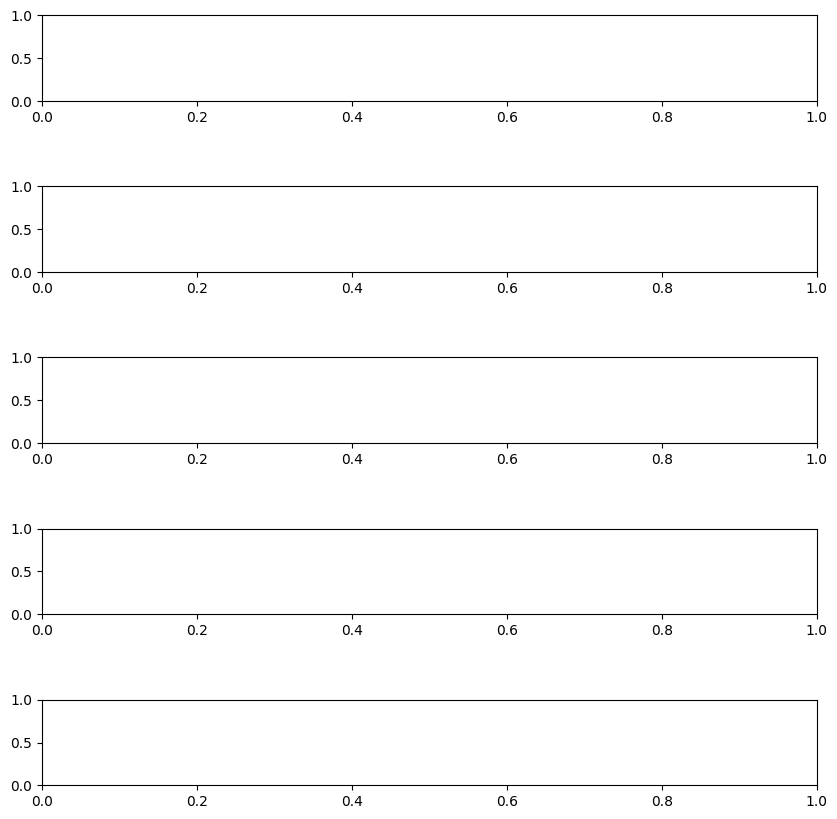

In [6]:
plot_trend_over_time(df_cleaned)

In [ ]:
plot_average_daily_trend(df)

In [ ]:
# Data Pre-processing
df_clean = df_original
# time wrt midnight, since we need to include time in our model
df_clean['relative_time'] = pd.to_timedelta(df_clean['time']).dt.total_seconds()
# convert to sin graph to have continuous values
df_clean['relative_time'] = np.sin(2 * np.pi * df_clean['relative_time'] / 86400)
df_clean  = df.drop(columns=['date_time', 'time'])

# Use StandardScaler to standardize all features
X = df_clean.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
df_standardized = pd.DataFrame(X, columns=df_clean.columns)
df_standardized.describe()

In [ ]:
def df_window_slicing(df: pd.DataFrame, window_size=60):
    df_values = df.values
    X = []
    y = []

    for i in range(len(df_values) - window_size):
        features = df_values[i:i + window_size]
        output = df_values[i + window_size]

        X.append(features)
        y.append(output)

    return np.array(X), np.array(y)

X, y = df_window_slicing(df_standardized, window_size=60)
X.shape, y.shape

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [ ]:
model1 = Sequential()

model1.add(LSTM(64, input_shape=(60, 7)))
model1.add(Dense(7, 'linear'))

model1.summary()

# model2 = Sequential()
# model2.add(InputLayer(input_shape=(60, 7)))
# for _ in range(10):
#     model2.add(LSTM(75, return_sequences=True, activation=ELU()))
# # Single linear output layer
# model2.add(Dense(7, activation='linear'))
# # Compile the model with specified learning rate and batch size
# learning_rate = 0.0001
# batch_size = 200
# model2.build(input_shape=(None, 60, 7))

# model2.summary()

In [ ]:
# cp2 = ModelCheckpoint('model2/', save_best_only=True)
# model2.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
# model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

In [ ]:
tf.get_logger().setLevel(0)

# Training code
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[cp1])

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

test_predictions = model1.predict(X_test)
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actuals': y_test.flatten()})

test_predictions.shape, X_test.shape, y_test.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error

# Assuming 'train_results' contains 'Train Predictions' and 'Actuals' columns
y_pred = train_results['Train Predictions']
y_true = train_results['Actuals']

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate R-squared (R2) - Coefficient of Determination
r2 = r2_score(y_true, y_pred)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_true, y_pred)

tolerance = 0.1
correct_predictions = np.abs(y_true - y_pred) <= tolerance
accuracy = np.mean(correct_predictions) * 100

# Print the calculated metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Explained Variance: {explained_variance:.2f}")
print(f"Custom Accuracy (within {tolerance} tolerance): {accuracy:.2f}%")

In [ ]:
# X = sliding_windows[:, :-1]  # Input features (all except the last time step)
# y = sliding_windows[:, -1]  # Target (the last time step)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = keras.Sequential()
# model.add(keras.layers.LSTM(units=64, input_shape=(X.shape[1], X.shape[2])))
# model.add(keras.layers.Dense(1))  # Adjust the output layer as needed

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# y_pred = model.predict(X_test)
# mse = np.mean((y_pred - y_test) ** 2)
# print(f"Mean Squared Error: {mse}")